In [12]:
from nilmtk import *
from nilmtk.disaggregate import fhmm_exact

In [10]:
import time

In [3]:
train = DataSet('/data/REDD/redd.h5')
test = DataSet('/data/REDD/redd.h5')

In [4]:
building = 2
train.set_window(end="30-4-2011")
test.set_window(start="30-4-2011")

In [5]:
train_elec = train.buildings[building].elec
test_elec = test.buildings[building].elec

In [6]:
%matplotlib inline

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was se

/Users/nipunbatra/git/nilmtk/nilmtk/utils.py:390: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill(limit=1)
  data = data.resample(**resample_kwargs)
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/dateutil/rrule.py:470: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:90: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:667: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


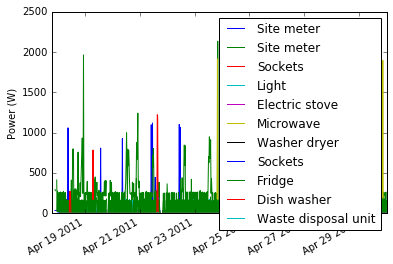

In [7]:
train_elec.plot()

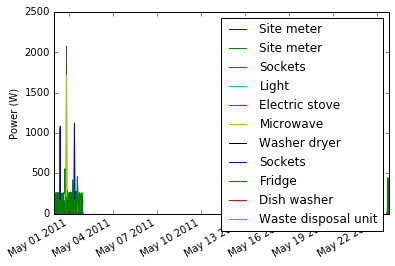

In [8]:
test_elec.plot()

In [13]:
start = time.time()
fhmm = fhmm_exact.FHMM()
fhmm.train(train_elec, sample_period=60)
end = time.time()
print("Runtime =", end-start, "seconds.")

Training model for submeter 'ElecMeter(instance=3, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=2, dataset='REDD', appliances=[Appliance(type='electric stove', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=7, building=2, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, d

In [14]:
disag_filename = '/data/REDD/redd-disag-fhmm.h5'
output = HDFDataStore(disag_filename, 'w')

In [15]:
fhmm.disaggregate(test_elec.mains(), output, sample_period=60)
output.close()

/Users/nipunbatra/git/nilmtk/nilmtk/metergroup.py:902: UserWarning: As a quick implementation we only get Good Sections from the first meter in the meter group.  We should really return the intersection of the good sections for all meters.  This will be fixed...
  warn("As a quick implementation we only get Good Sections from"
/Users/nipunbatra/git/nilmtk/nilmtk/stats/goodsectionsresults.py:145: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  return df.convert_objects()


Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.


ValueError: invalid combinate of [values_axes] on appending data [name->values_block_0,cname->values_block_0,dtype->float64,kind->float,shape->(1, 1319)] vs current table [name->values_block_0,cname->values_block_0,dtype->float32,kind->float,shape->None]

In [ ]:
disag_fhmm = DataSet(disag_filename)
disag_fhmm_elec = disag_fhmm.buildings[building].elec